In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [9]:
zehn.data <- Read10X(data.dir = "/home/rstudio/run070/run070-nsclc-3_RSEC_MolsPerCell_MEX")

In [10]:
zehn <- CreateSeuratObject(counts = zehn.data, project = "zehn_dataset", min.cells = 3, min.features = 200)
ncol(zehn)

[1] 5755

In [11]:
Assays(zehn) # Assay (v5) data with 16485 features for 802 cells
zehn[["RNA"]]
GetAssayData(zehn, slot = "counts")[, 1:30] #counts are inside Assays

[1] "RNA"

Assay (v5) data with 23691 features for 5755 cells
First 10 features:
 A1BG, A1BG-AS1, A1CF, A2M, A2M-AS1, A2ML1, A2ML1-AS1, A3GALT2, AAAS,
AACS 
Layers:
 counts 

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
  [[ suppressing 30 column names ‘4100’, ‘4977’, ‘11356’ ... ]]

  [[ suppressing 30 column names ‘4100’, ‘4977’, ‘11356’ ... ]]

  [[ suppressing 30 column names ‘4100’, ‘4977’, ‘11356’ ... ]]



23691 x 30 sparse Matrix of class "dgCMatrix"
                                                                                      
A1BG                        .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
A1BG-AS1                    .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
A1CF                        .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
A2M                         .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
A2M-AS1                     .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
A2ML1                       .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  1  .  . .
A2ML1-AS1                   .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
A3GALT2                     .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  1  . .
AAAS                        4  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  . .
AACS                        .  .  .  .  .  .  .  .  .  .  .  .  . . .  .  .  .  .  .

In [12]:
#QC
#calculates the percentage of counts originating from a set of features
#mitochondrial contamination
zehn[["percent.mt"]] <- PercentageFeatureSet(zehn, pattern = "^MT-")

In [13]:
# Show QC metrics for the first 5 cells ## the percent.mt is also added here
head(zehn@meta.data, 5)

orig.ident   nCount_RNA nFeature_RNA percent.mt
4100  zehn_dataset 23935      5941          4.904951 
4977  zehn_dataset  1920       912         12.760417 
11356 zehn_dataset  1299       836          4.080062 
21277 zehn_dataset  2243      1335          6.776638 
30102 zehn_dataset  2860      1681          5.524476

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


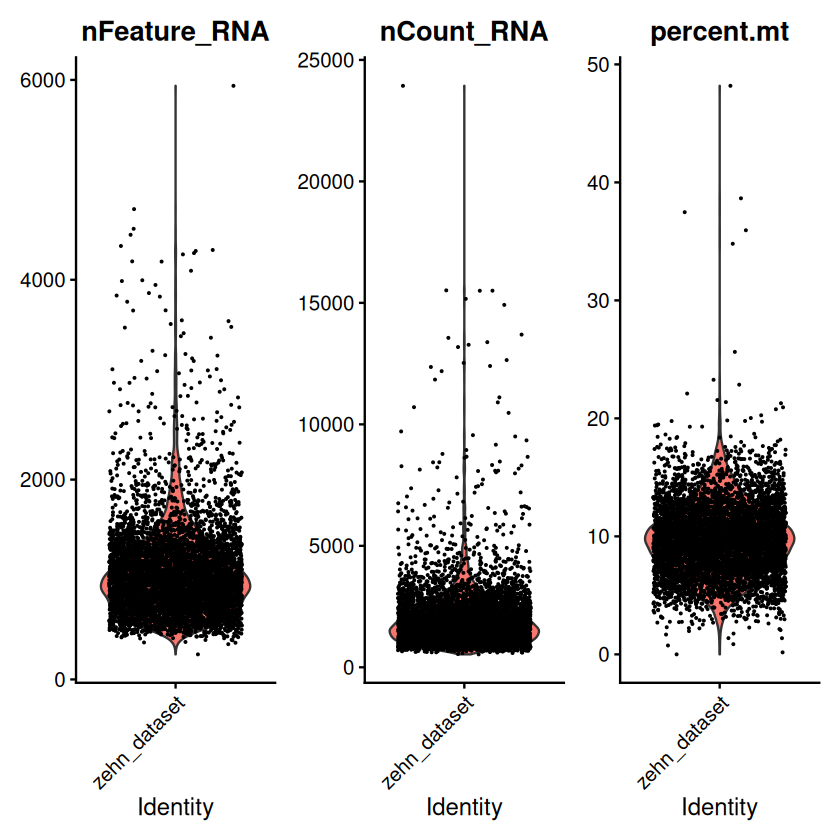

In [14]:
# Violin Plot
VlnPlot(zehn, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

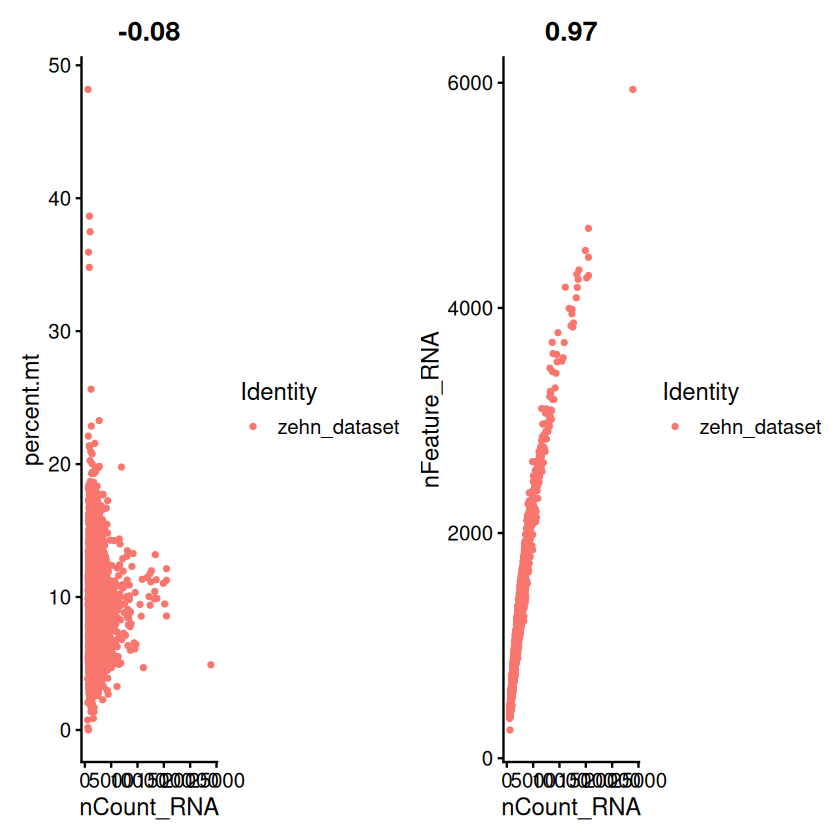

In [15]:
# func. FeatureScatter
plot1 <- FeatureScatter(zehn, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(zehn, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


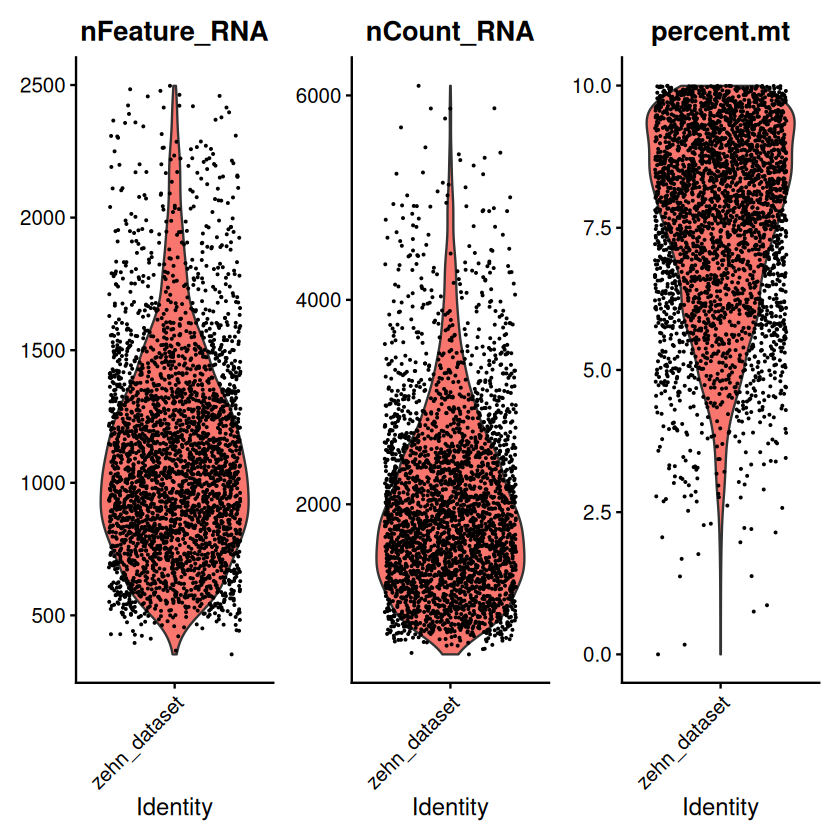

In [16]:
zehn_s <- subset(zehn, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)
VlnPlot(zehn_s, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [17]:
#zehn_s <- NormalizeData(zehn_s, normalization.method = "LogNormalize", scale.factor = 10000)
zehn_s <- NormalizeData(zehn_s)

Normalizing layer: counts



In [18]:
zehn_s <- FindVariableFeatures(zehn_s, selection.method = "vst", nfeatures = 2000)
zehn_s
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(zehn_s), 10)

Finding variable features for layer counts



An object of class Seurat 
23691 features across 3105 samples within 1 assay 
Active assay: RNA (23691 features, 2000 variable features)
 2 layers present: counts, data

In [19]:
head(VariableFeatures(zehn_s), 10)

[1] "HSPA1A" "GNLY"   "HSPA1B" "TUBB"   "CXCL13" "TYMS"   "CCL4"   "MKI67" 
 [9] "SOX4"   "CCL4L2"

In [20]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(zehn_s)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
pdf("/home/rstudio/variable_features_plot_with_labels.pdf", width = 12, height = 10)
plot1 + plot2
dev.off()

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


pdf 
  2

In [21]:
# Scaling needed prior to dimensionality red.n
# ScaleData() Shifts mean expression across cells to 0, Scales the variance across cells to 1
all.genes <- rownames(zehn_s)
#rownames(zehn_s)
zehn_s <- ScaleData(zehn_s, features = all.genes)
zehn_s[["RNA"]]$scale.data

Centering and scaling data matrix



11356       21277       30102       41586       41975      
A1BG        -0.03993615 -0.03993615 -0.03993615 -0.03993615 -0.03993615
A1BG-AS1    -0.12253429 -0.12253429 -0.12253429 -0.12253429 -0.12253429
A1CF        -0.03086090 -0.03086090 -0.03086090 -0.03086090 -0.03086090
A2M         -0.10172846 -0.10172846 -0.10172846 -0.10172846 -0.10172846
A2M-AS1     -0.06406874 -0.06406874 -0.06406874 -0.06406874 -0.06406874
A2ML1       -0.05810020 -0.05810020 -0.05810020 -0.05810020 -0.05810020
A2ML1-AS1   -0.10099961 -0.10099961 -0.10099961 -0.10099961 -0.10099961
A3GALT2     -0.06858379 -0.06858379 -0.06858379 -0.06858379 -0.06858379
AAAS        -0.14745670 -0.14745670 -0.14745670 -0.14745670 -0.14745670
AACS        -0.14637903 -0.14637903 -0.14637903 -0.14637903 -0.14637903
AACSP1      -0.04275012 -0.04275012 -0.04275012 -0.04275012 -0.04275012
AADACL2-AS1 -0.03074566 -0.03074566 -0.03074566 -0.03074566 -0.03074566
AADACL3     -0.03098999 -0.03098999 -0.03098999 -0.03098999 -0.03098999
AAGAB       -0.22825146 -0.22825146 -0.22825146 -0.22825146 -0.22825146
AAK1         1.95422287  1.41617928  1.19236173 -0.54342528 -0.54342528
AAMDC       -0.11636404 -0.11636404 -0.11636404 -0.11636404 -0.11636404
AAMP        -0.32841803 -0.32841803 -0.32841803 -0.32841803 -0.32841803
AANAT       -0.03090994 -0.03090994 -0.03090994 -0.03090994 -0.03090994
AAR2        -0.21892518 -0.21892518 -0.21892518 -0.21892518 -0.21892518
AARS1       -0.25967116 -0.25967116 -0.25967116 -0.25967116 -0.25967116
AARS2       -0.13320532 -0.13320532 -0.13320532 -0.13320532 -0.13320532
AARSD1      -0.06866944 -0.06866944 -0.06866944 -0.06866944 -0.06866944
AASDH       -0.16765095 -0.16765095 -0.16765095 -0.16765095 -0.16765095
AASDHPPT    -0.27787860 -0.27787860 -0.27787860  3.40847403 -0.27787860
AASS        -0.08693796 -0.08693796 -0.08693796 -0.08693796 -0.08693796
AATF        -0.31364928 -0.31364928 -0.31364928 -0.31364928 -0.31364928
AATK        -0.02526713 -0.02526713 -0.02526713 -0.02526713 -0.02526713
ABALON      -0.03439279 -0.03439279 -0.03439279 -0.03439279 -0.03439279
ABAT        -0.21027074 -0.21027074 -0.21027074 -0.21027074 -0.21027074
ABCA1       -0.05551922 -0.05551922 -0.05551922 -0.05551922 -0.05551922
⋮           ⋮           ⋮           ⋮           ⋮           ⋮          
ZSCAN22     -0.09353841 -0.09353841 -0.09353841 -0.09353841 -0.09353841
ZSCAN25     -0.22224599 -0.22224599 -0.22224599 -0.22224599 -0.22224599
ZSCAN26     -0.09797914 -0.09797914 -0.09797914 -0.09797914 -0.09797914
ZSCAN29     -0.17637254 -0.17637254 -0.17637254 -0.17637254 -0.17637254
ZSCAN30     -0.12005348 -0.12005348 -0.12005348 -0.12005348 -0.12005348
ZSCAN31     -0.05557590 -0.05557590 -0.05557590 -0.05557590 -0.05557590
ZSCAN32     -0.17777937 -0.17777937 -0.17777937 -0.17777937 -0.17777937
ZSCAN5A     -0.10980495 -0.10980495 -0.10980495 -0.10980495 -0.10980495
ZSCAN5A-AS1 -0.02472028 -0.02472028 -0.02472028 -0.02472028 -0.02472028
ZSCAN9      -0.10182184 -0.10182184 -0.10182184 -0.10182184 -0.10182184
ZSWIM1      -0.06371589 -0.06371589 -0.06371589 -0.06371589 -0.06371589
ZSWIM3      -0.10725031 -0.10725031 -0.10725031 -0.10725031 -0.10725031
ZSWIM4      -0.12129996 -0.12129996 -0.12129996 -0.12129996 -0.12129996
ZSWIM5      -0.13557026 -0.13557026 -0.13557026 -0.13557026 -0.13557026
ZSWIM6      -0.41950865 -0.41950865 -0.41950865 -0.41950865 -0.41950865
ZSWIM7      -0.18679075 -0.18679075 -0.18679075 -0.18679075 -0.18679075
ZSWIM8      -0.20640052 -0.20640052 -0.20640052 -0.20640052 -0.20640052
ZSWIM9      -0.07839600 -0.07839600 -0.07839600 -0.07839600 -0.07839600
ZUP1        -0.18224064 -0.18224064 -0.18224064 -0.18224064  7.27150016
ZW10        -0.14894171 -0.14894171 -0.14894171 -0.14894171 -0.14894171
ZWILCH      -0.25294199 -0.25294199 -0.25294199 -0.25294199 -0.25294199
ZWINT       -0.18239749  5.25599946 -0.18239749 -0.18239749 -0.18239749
ZXDA        -0.10182308 -0.10182308 -0.10182308 -0.10182308 -0.10182308
ZXDB        -0.17895757 -0.17895757 -0.17895757 -0.1

In [22]:
### SCTransform() can also be used. As with ScaleData(), the function SCTransform() also includes a vars.to.regress parameter.

#zehn_s <- RunPCA(zehn_s, features = VariableFeatures(object = zehn_s))
#print(zehn_s[["pca"]], dims = 1:5, nfeatures = 5)
#npcs <- min(50, min_dim - 1)

# Print dimensions
print(paste("Number of cells:", ncol(zehn_s)))
print(paste("Number of variable features:", length(VariableFeatures(zehn_s))))
print(paste("Maximum possible PCs:", min(ncol(zehn_s), length(VariableFeatures(zehn_s))) - 1))

zehn_s <- RunPCA(zehn_s, features = VariableFeatures(object = zehn_s), npcs = 20)

[1] "Number of cells: 3105"
[1] "Number of variable features: 2000"
[1] "Maximum possible PCs: 1999"


PC_ 1 
Positive:  DUSP4, HLA-DRB1, CXCL13, RBPJ, MYO7A, GZMB, HSPA1A, TYMS, MKI67, CCL5 
	   ITGAE, RRM2, NKG7, TOP2A, HLA-DRA, CTLA4, PMAIP1, RGS1, VCAM1, PRDM1 
	   CD74, HLA-DRB6, STMN1, ENTPD1, APOBEC3C, HAVCR2, ASPM, TOX, IKZF3, TPX2 
Negative:  IL7R, KLF2, PABPC1, SELL, FTH1, ANXA1, RPS18, SATB1, SESN3, LEF1 
	   LNCRNA-IUR, CCR7, FOS, YBX3, SNED1, ZBTB16, FAM107B, ZBTB18, IRS2, SLC2A3 
	   RNF130, ENSG00000266049, KRT1, BACH2, ACTN1, ABLIM1, ZHX2, NR3C2, TAF4B, FAAH2 
PC_ 2 
Positive:  RRM2, TOP2A, MKI67, NCAPG, TUBB, TYMS, STMN1, KIF18B, ASPM, UBE2C 
	   CDK1, KIF11, CDCA5, CENPU, CDKN3, PKMYT1, BIRC5, FAM111B, CEP55, ASF1B 
	   RAD51AP1, FOXM1, ZWINT, HJURP, CDCA3, DLGAP5, TUBA1B, ESPL1, CDCA2, CKAP2L 
Negative:  CCL5, DUSP4, MYO7A, TNFRSF9, CBLB, LYST, NKG7, KRT86, PRF1, AKAP5 
	   ETV1, CXCR6, RGS1, SNX9, RBPJ, DTHD1, LAYN, ITGAE, PRDM1, IKZF3 
	   CXCL13, TOX, ENSG00000287347, KLRD1, ADGRG1, RYR2, HAVCR2, HSPA1A, ASXL2, SAMSN1 
PC_ 3 
Positive:  GZMK, DUSP2, CCL5, AUTS2, CD

PC_ 1 
Positive:  DUSP4, HLA-DRB1, CXCL13, RBPJ, MYO7A 
Negative:  IL7R, KLF2, PABPC1, SELL, FTH1 
PC_ 2 
Positive:  RRM2, TOP2A, MKI67, NCAPG, TUBB 
Negative:  CCL5, DUSP4, MYO7A, TNFRSF9, CBLB 
PC_ 3 
Positive:  GZMK, DUSP2, CCL5, AUTS2, CD74 
Negative:  SESN3, LNCRNA-IUR, SELL, SNX9, IRS2 
PC_ 4 
Positive:  FOSB, RGCC, FOS, NR4A1, NR4A2 
Negative:  MAF, AOAH, ENSG00000248710, HLA-DRB6, PDE3B 
PC_ 5 
Positive:  ENC1, GZMK, CRTAM, PHACTR2, REL 
Negative:  TOB1, RSAD2, ANXA1, GNLY, HSPA1B 


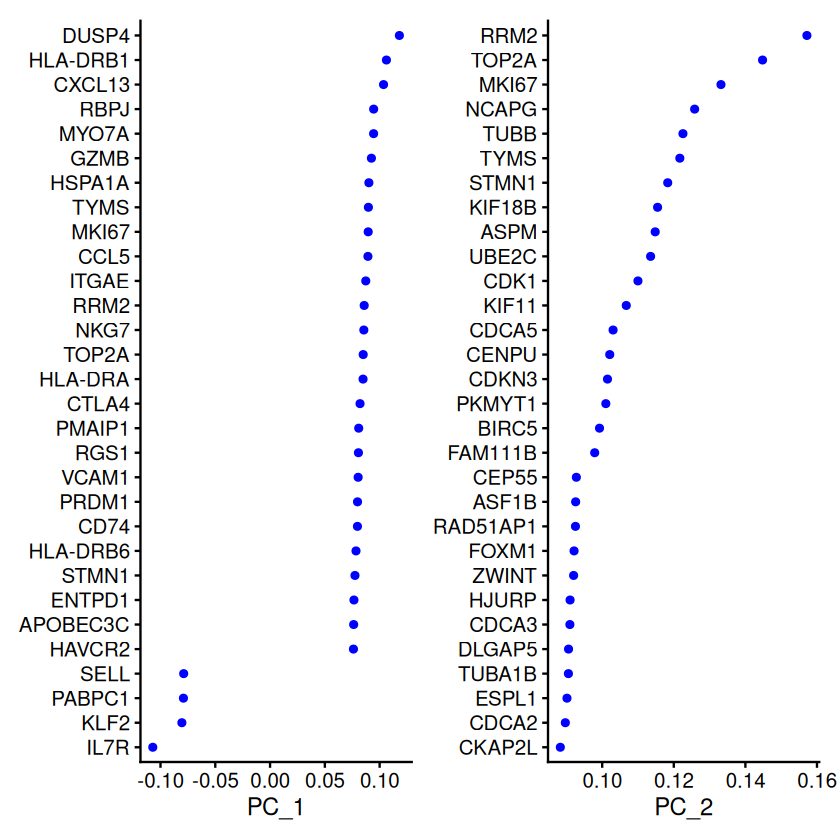

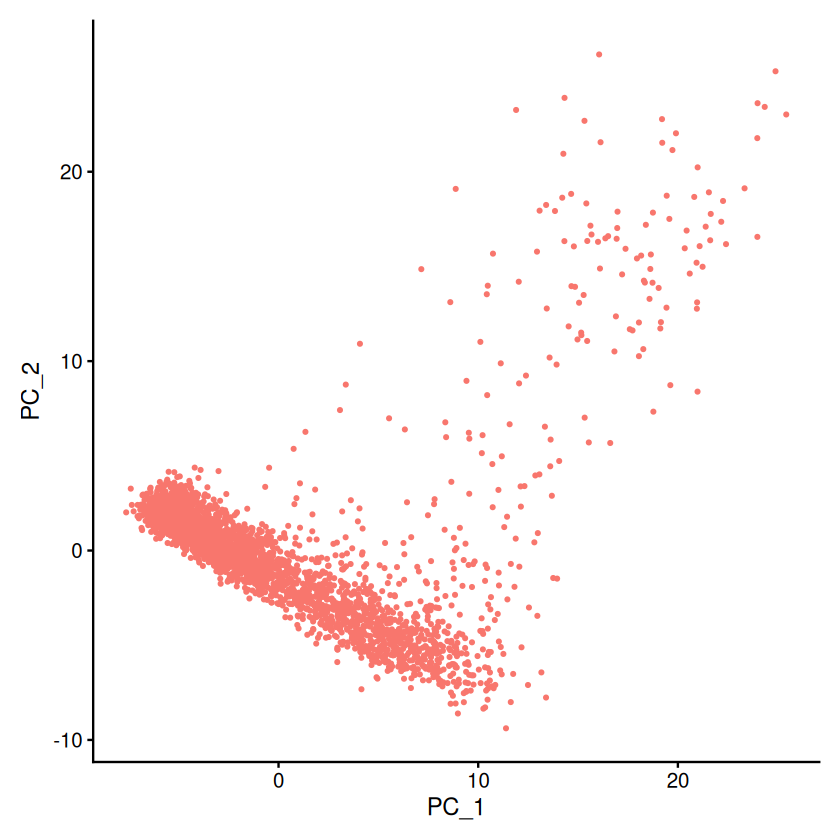

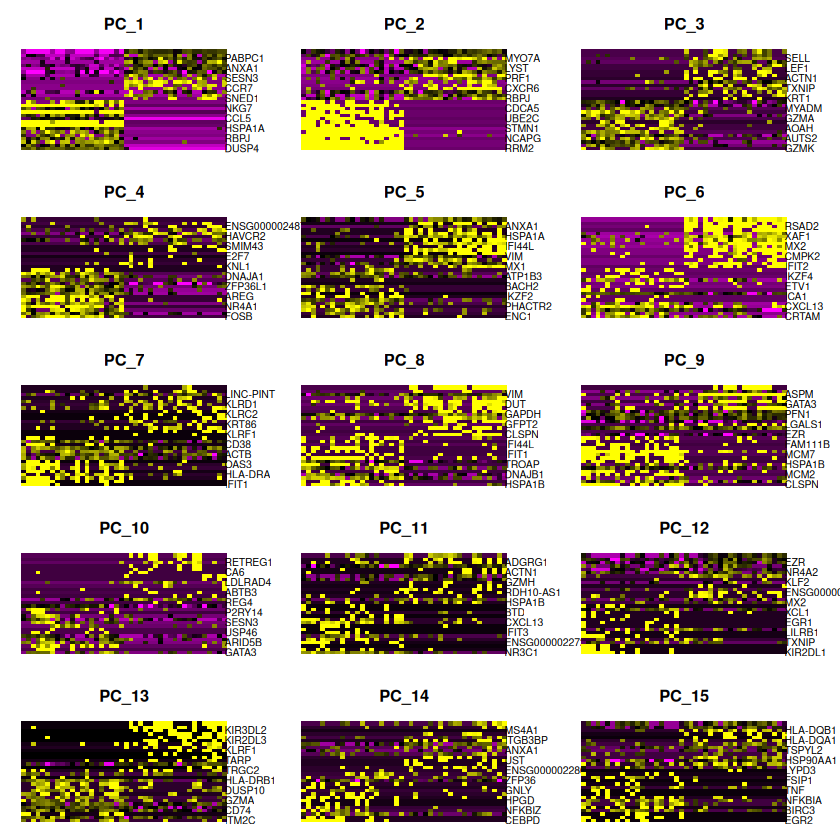

In [23]:
# PCA results interpreted in different ways
print(zehn_s[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(zehn_s, dims = 1:2, reduction = "pca")
DimPlot(zehn_s, reduction = "pca") + NoLegend()
#DimHeatmap(zehn_s, dims = 1, cells = 42, balanced = TRUE)
DimHeatmap(zehn_s, dims = 1:15, cells = 42, balanced = TRUE)

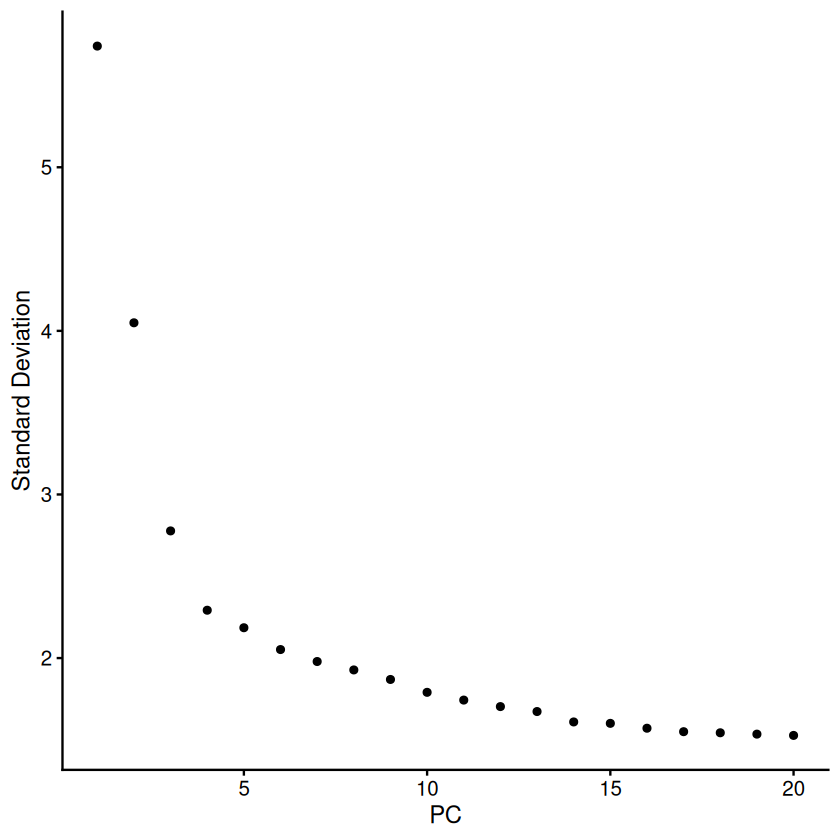

In [24]:
# ElbowPlot to understand the capture power of principal components
ElbowPlot(zehn_s) # Confusing results # elbow at 6 with percent.mt < 10

In [25]:
zehn_s <- FindNeighbors(zehn_s, dims = 1:20) # construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights # increasing from 1:10
zehn_s <- FindClusters(zehn_s, resolution = 1.0) # Group cells together, with the goal of optimizing the standard modularity function ## res 0.5 too low.
head(Idents(zehn_s)) # 4 levels/clusters

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3105
Number of edges: 130967

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7178
Number of communities: 9
Elapsed time: 0 seconds


11356 21277 30102 41586 41975 66729 
    2     1     7     6     6     2 
Levels: 0 1 2 3 4 5 6 7 8

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:19:07 UMAP embedding parameters a = 0.9922 b = 1.112

14:19:07 Read 3105 rows and found 10 numeric columns

14:19:07 Using Annoy for neighbor search, n_neighbors = 30

14:19:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:19:07 Writing NN index file to temp file /tmp/RtmpxwON7L/file2d54a026e06

14:19:07 Searching Annoy index using 1 thread, search_k = 3000

14:19:07 Annoy recall = 100%

14:19:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

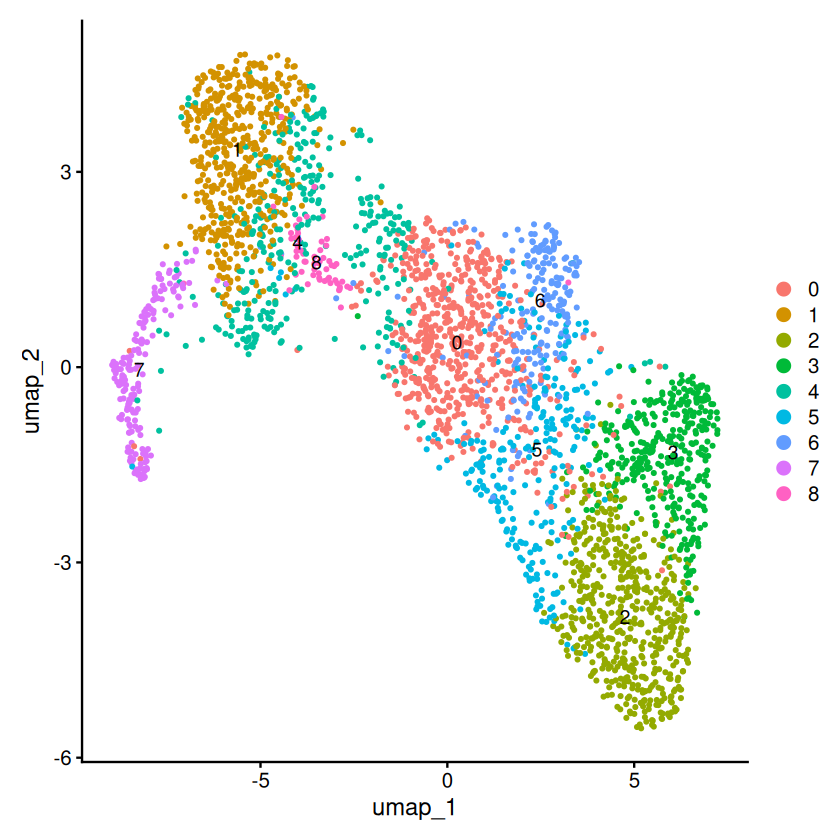

In [26]:
# Non-linear dimensional reduction (UMAP/tSNE)

zehn_s <- RunUMAP(zehn_s, dims = 1:10)
DimPlot(zehn_s, reduction = "umap", label = TRUE)

In [27]:
# marker finding ## What is this exactly?
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
zehn_s.markers <- FindAllMarkers(zehn_s, only.pos = TRUE)
zehn_s.markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene           
1    6.517438e-122 2.364048   0.569 0.139 1.544046e-117 0       GZMK           
2     3.893262e-61 1.284782   0.744 0.454  9.223526e-57 0       DUSP2          
3     3.026915e-53 1.977041   0.399 0.139  7.171064e-49 0       AOAH           
4     1.979596e-49 2.422679   0.271 0.069  4.689862e-45 0       ENC1           
5     6.305315e-44 2.633933   0.220 0.050  1.493792e-39 0       DKK3           
6     4.371872e-35 1.533144   0.419 0.204  1.035740e-30 0       AUTS2          
7     3.268061e-25 1.157127   0.434 0.248  7.742363e-21 0       CST7           
8     2.380809e-24 1.195711   0.436 0.250  5.640376e-20 0       SYNE1          
9     6.819805e-22 2.150254   0.133 0.035  1.615680e-17 0       ENSG00000240535
10    1.040942e-20 1.303309   0.270 0.122  2.466096e-16 0       MAF            
11    1.035435e-19 1.151590   0.339 0.183  2.453049e-15 0       ITM2C          
12    2.098294e-19 3.260014   0.063 0.008  4.971068e-15 0       MS4A1          
13    2.388088e-17 2.269834   0.106 0.029  5.657619e-13 0       PLEK           
14    1.154617e-16 1.502262   0.210 0.093  2.735404e-12 0       EPHA4          
15    2.761476e-15 1.639007   0.173 0.072  6.542212e-11 0       CMC1           
16    1.634285e-14 1.806189   0.113 0.037  3.871784e-10 0       ITGA5          
17    5.391268e-14 1.237827   0.255 0.136  1.277245e-09 0       TC2N           
18    1.851105e-13 2.125998   0.085 0.024  4.385453e-09 0       FCRL6          
19    2.046502e-13 3.116338   0.047 0.007  4.848368e-09 0       LGR6           
20    4.461622e-13 1.795996   0.090 0.026  1.057003e-08 0       SYNM           
21    1.942070e-12 1.061766   0.276 0.163  4.600957e-08 0       PHACTR2        
22    2.433414e-12 1.036370   0.301 0.185  5.765002e-08 0       BCL9L          
23    2.920702e-12 1.885842   0.095 0.031  6.919434e-08 0       C1orf21        
24    5.720160e-11 1.128643   0.228 0.129  1.355163e-06 0       MIDN           
25    5.768273e-11 1.199458   0.238 0.139  1.366562e-06 0       EOMES          
26    6.506349e-11 1.144554   0.240 0.139  1.541419e-06 0       MAP3K8         
27    2.707550e-10 2.910228   0.038 0.006  6.414456e-06 0       PACSIN1        
28    4.624323e-10 1.374677   0.155 0.077  1.095548e-05 0       MICAL2         
29    2.652553e-09 1.160364   0.181 0.099  6.284164e-05 0       LRIG1          
30    2.690959e-09 1.077229   0.201 0.115  6.375151e-05 0       P2RY8          
⋮    ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮              
5274 0.008741849   3.199050   0.017 0.002 1             8       PLPP4          
5275 0.008741849   3.192636   0.017 0.002 1             8       SLC19A3        
5276 0.008791009   2.745577   0.017 0.002 1             8       B4GAT1-DT      
5277 0.008791009   3.332047   0.017 0.002 1             8       ENSG00000244345
5278 0.008791009   3.122135   0.017 0.002 1             8       ENSG00000264520
5279 0.008791009   3.018695   0.017 0.002 1             8       ENSG00000286664
5280 0.008791009   3.065507   0.017 0.002 1             8       ISY1-RAB43     
5281 0.008791009   3.066533   0.017 0.002 1             8       LCMT1-AS1      
5282 0.008791009   2.633474   0.017 0.002 1             8       NLRC4          
5283 0.008791009   2.994739   0.017 0.002 1             8       PDZD7          
5284 0.008791009   3.076023   0.017 0.002 1             8       RGS5-AS1       
5285 0.008791009   2.919647   0.017 0.002 1             8       SCN10A         
5286 0.008791009   3.064442   0.017 0.002 1             8       SIX5           
5287 0.008791009   2.891615   0.017 0.002 1             8       TGM2           
5288 0.008840416   3.277511   0.017 0.002 1             8       CUEDC1         
5289 0.008840416   2.686178   0.017 0.002 1             8       GALNT15        
5290 0.008840416   2.359699   0.017 0.002 1             8       PDE7A-DT       
5291 0.009038555   1.762387   0.033 0.006 1             8       WNK3           
5292 

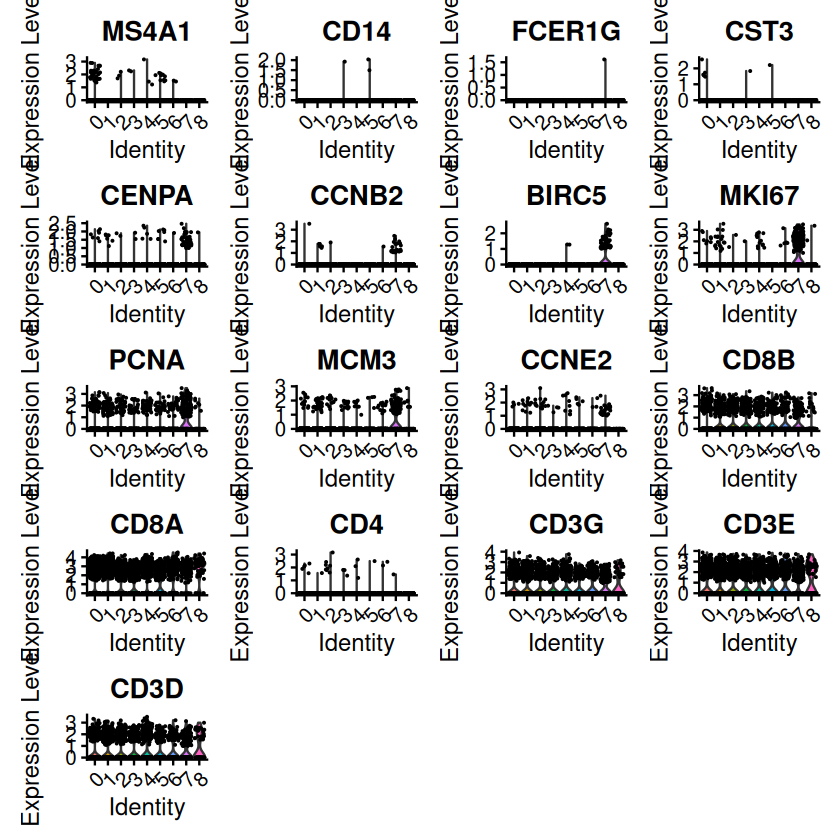

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene           
1  6.517438e-122 2.364048   0.569 0.139 1.544046e-117 0       GZMK           
2   3.893262e-61 1.284782   0.744 0.454  9.223526e-57 0       DUSP2          
3   3.026915e-53 1.977041   0.399 0.139  7.171064e-49 0       AOAH           
4   1.979596e-49 2.422679   0.271 0.069  4.689862e-45 0       ENC1           
5   6.305315e-44 2.633933   0.220 0.050  1.493792e-39 0       DKK3           
6   4.371872e-35 1.533144   0.419 0.204  1.035740e-30 0       AUTS2          
7   3.268061e-25 1.157127   0.434 0.248  7.742363e-21 0       CST7           
8   2.380809e-24 1.195711   0.436 0.250  5.640376e-20 0       SYNE1          
9   6.819805e-22 2.150254   0.133 0.035  1.615680e-17 0       ENSG00000240535
10  1.040942e-20 1.303309   0.270 0.122  2.466096e-16 0       MAF            
11 1.071873e-207 3.425155   0.610 0.074 2.539375e-203 1       MYO7A          
12 1.621225e-146 3.948176   0.385 0.032 3.840845e-142 1       KRT86          
13 3.330520e-146 1.510069   0.985 0.535 7.890335e-142 1       DUSP4          
14 4.508424e-145 2.012513   0.843 0.322 1.068091e-140 1       SNX9           
15 8.789898e-142 2.166934   0.624 0.125 2.082415e-137 1       CXCL13         
16 1.768447e-140 2.133270   0.790 0.280 4.189628e-136 1       RBPJ           
17 8.988258e-134 3.183045   0.429 0.054 2.129408e-129 1       LAYN           
18 6.149279e-120 2.706065   0.483 0.087 1.456826e-115 1       HAVCR2         
19 2.129606e-119 2.115956   0.608 0.146 5.045249e-115 1       GZMB           
20 8.832808e-119 2.944902   0.451 0.075 2.092580e-114 1       VCAM1          
21 4.077155e-126 1.009777   0.998 0.943 9.659187e-122 2       RPL34          
22 2.967136e-125 2.356177   0.638 0.176 7.029443e-121 2       LNCRNA-IUR     
23 7.368075e-122 2.329208   0.636 0.177 1.745571e-117 2       SESN3          
24 1.501674e-119 1.369850   0.974 0.808 3.557616e-115 2       FTH1           
25 1.032491e-105 4.769455   0.236 0.011 2.446073e-101 2       KRT1           
26 6.917809e-105 1.001989   0.987 0.898 1.638898e-100 2       RPS6           
27  1.759611e-88 1.686321   0.692 0.272  4.168694e-84 2       SELL           
28  6.615849e-83 1.026706   0.970 0.611  1.567361e-78 2       IL7R           
29  5.352285e-78 1.001266   0.954 0.772  1.268010e-73 2       RPS12          
30  2.135405e-76 1.344843   0.831 0.464  5.058987e-72 2       ANXA1          
⋮  ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮              
61 8.339132e-135 3.938559   0.657 0.094 1.975624e-130 6       GNLY           
62  1.642827e-62 3.129002   0.474 0.099  3.892022e-58 6       GFPT2          
63  6.262371e-50 5.569058   0.127 0.005  1.483618e-45 6       KIR2DL1        
64  8.158335e-41 6.184684   0.075 0.001  1.932791e-36 6       TYROBP         
65  6.513642e-35 3.399995   0.192 0.027  1.543147e-30 6       SMIM3          
66  8.544386e-33 3.918729   0.155 0.018  2.024250e-28 6       CEBPD          
67  3.853964e-32 6.084639   0.061 0.001  9.130425e-28 6       KIR2DL3        
68  4.449575e-30 1.648609   0.545 0.223  1.054149e-25 6       AUTS2          
69  5.297293e-28 2.474499   0.249 0.055  1.254982e-23 6       MYBL1          
70  7.501577e-27 4.344322   0.094 0.007  1.777199e-22 6       KLRF1          
71  0.000000e+00 7.870730   0.554 0.004  0.000000e+00 7       RRM2           
72 3.981584e-307 5.554355   0.797 0.034 9.432772e-303 7       TYMS           
73 4.384044e-306 5.472491   0.667 0.016 1.038624e-301 7       MKI67          
74 1.885255e-292 5.886420   0.638 0.016 4.466357e-288 7       TOP2A          
75 1.909824e-237 5.634378   0.531 0.014 4.524565e-233 7       ASPM           
76 9.351798e-235 5.119790   0.582 0.020 2.215534e-230 7       CENPU          
77 3.778616e-223 6.226875   0.429 0.006 8.951919e-219 7       NCAPG          
78 3.221053e-219 4.359037   0.893 0.093 7.630996e-215 7       STMN1          
79 8.002216e-204 4.991251   0.475 0.013 1.895805e-199 7       KIF11          
80 8.021547e-187 4.923321

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
GZMK            6.517438e-122 2.3640480  0.569 0.139 1.544046e-117 0      
DUSP2            3.893262e-61 1.2847817  0.744 0.454  9.223526e-57 0      
AOAH             3.026915e-53 1.9770408  0.399 0.139  7.171064e-49 0      
ENC1             1.979596e-49 2.4226794  0.271 0.069  4.689862e-45 0      
DKK3             6.305315e-44 2.6339327  0.220 0.050  1.493792e-39 0      
PPP2R5C          2.915842e-35 0.6808392  0.855 0.756  6.907921e-31 0      
AUTS2            4.371872e-35 1.5331440  0.419 0.204  1.035740e-30 0      
CD74             2.645317e-31 0.6473241  0.875 0.736  6.267021e-27 0      
RUNX3            3.844476e-29 0.7199868  0.819 0.718  9.107947e-25 0      
MALAT1           2.536236e-26 0.4056200  0.980 0.979  6.008596e-22 0      
CST7             3.268061e-25 1.1571265  0.434 0.248  7.742363e-21 0      
PIK3R1           1.761574e-24 0.8386313  0.667 0.523  4.173345e-20 0      
SYNE1            2.380809e-24 1.1957106  0.436 0.250  5.640376e-20 0      
FYN              1.057220e-22 0.4787831  0.922 0.834  2.504660e-18 0      
CALM1            1.325008e-22 0.4856741  0.923 0.889  3.139076e-18 0      
YPEL5            1.530417e-22 0.6514744  0.752 0.607  3.625711e-18 0      
ATP1B3           5.214773e-22 0.7632395  0.807 0.712  1.235432e-17 0      
ENSG00000240535  6.819805e-22 2.1502538  0.133 0.035  1.615680e-17 0      
SRGN             7.526825e-21 0.3565074  0.973 0.961  1.783180e-16 0      
MAF              1.040942e-20 1.3033094  0.270 0.122  2.466096e-16 0      
ITM2C            1.035435e-19 1.1515900  0.339 0.183  2.453049e-15 0      
MS4A1            2.098294e-19 3.2600138  0.063 0.008  4.971068e-15 0      
TALAM1           6.194543e-19 0.3814256  0.985 0.977  1.467549e-14 0      
PLEK             2.388088e-17 2.2698344  0.106 0.029  5.657619e-13 0      
HLA-B            3.738341e-17 0.1695973  1.000 1.000  8.856504e-13 0      
EPHA4            1.154617e-16 1.5022616  0.210 0.093  2.735404e-12 0      
TENT4B           2.347544e-16 0.9687330  0.419 0.279  5.561566e-12 0      
FAM177A1         1.294047e-15 0.6338703  0.606 0.477  3.065726e-11 0      
H3-3B            1.466472e-15 0.5278025  0.827 0.776  3.474219e-11 0      
CMC1             2.761476e-15 1.6390073  0.173 0.072  6.542212e-11 0      
⋮               ⋮             ⋮          ⋮     ⋮     ⋮             ⋮      
B4GAT1-DT       0.008791009   2.7455771  0.017 0.002 1             8      
ENSG00000244345 0.008791009   3.3320473  0.017 0.002 1             8      
ENSG00000264520 0.008791009   3.1221346  0.017 0.002 1             8      
ENSG00000286664 0.008791009   3.0186945  0.017 0.002 1             8      
ISY1-RAB43      0.008791009   3.0655072  0.017 0.002 1             8      
LCMT1-AS1       0.008791009   3.0665335  0.017 0.002 1             8      
NLRC4           0.008791009   2.6334740  0.017 0.002 1             8      
PDZD7           0.008791009   2.9947387  0.017 0.002 1             8      
RGS5-AS1        0.008791009   3.0760232  0.017 0.002 1             8      
SCN10A          0.008791009   2.9196467  0.017 0.002 1             8      
SIX5            0.008791009   3.0644418  0.017 0.002 1             8      
TGM2            0.008791009   2.8916154  0.017 0.002 1             8      
CUEDC1          0.008840416   3.2775106  0.017 0.002 1             8      
GALNT15         0.008840416   2.6861782  0.017 0.002 1             8      
PDE7A-DT        0.008840416   2.3596990  0.017 0.002 1             8      
ITGA14          0.008899994   0.9226838  0.317 0.183 1             8      
WNK3            0.009038555   1.7623871  0.033 0.006 1             8      
VAMP5           0.009216187   1.7570899  0.083 0.027 1             8      
BST22           0.009240879   1.9908771  0.083 0.028 1             8      
FHIP2A2         0.009283326   1.4019671  0.200 0.102 1             8      
PARP122         0.009324312   1.6112975  0.133 0.056 1             8      
ZEB24           0.009363106   0.6050820  

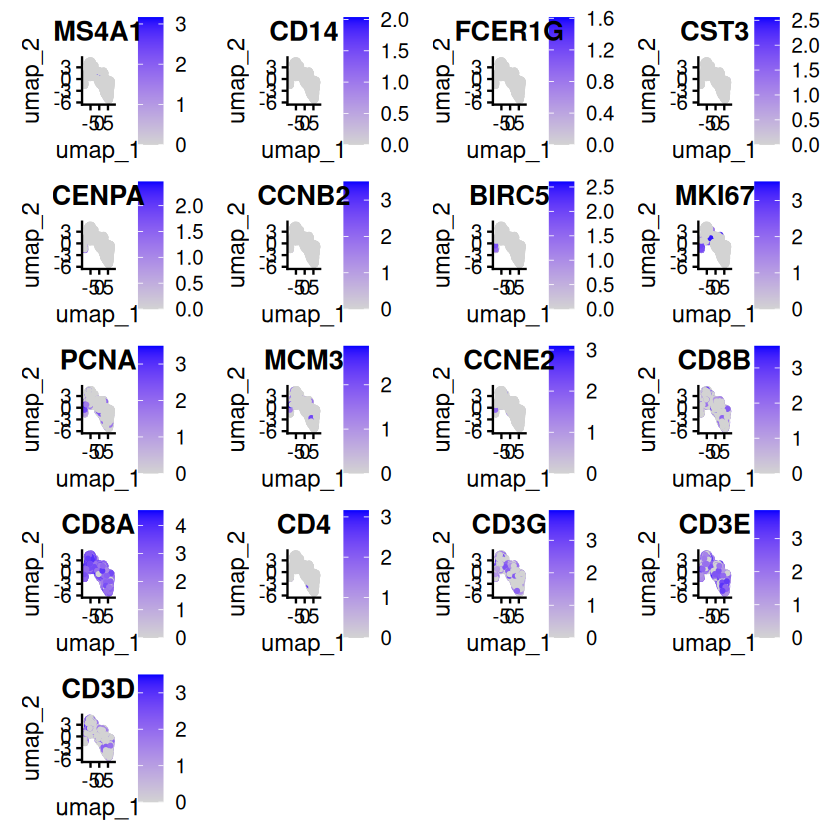

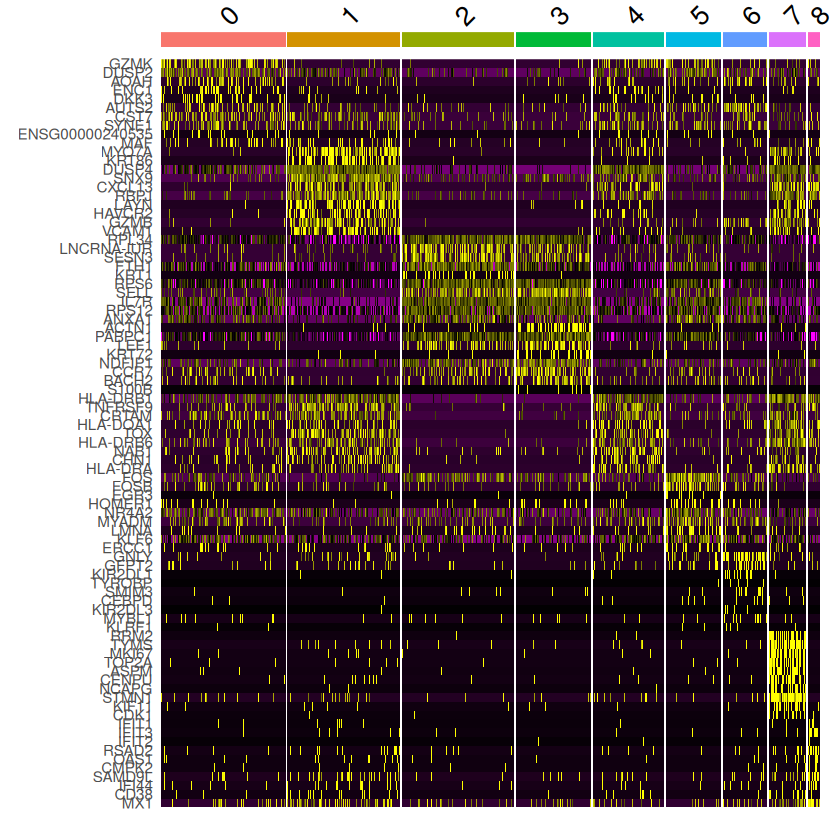

In [51]:
# Marker expression visualization
#VlnPlot(zehn_s, features = c("JADE2", "DEK", "CDK2AP2")) #Cluster 1 could represent a population of activated or metabolically active cells (since all three genes are upregulated). Cluster 3 might represent a transition or differentiation state. Clusters 0 and 2 are likely in a resting or low-activity state.
#FeaturePlot(zehn_s, features = c("JADE2", "DEK", "CDK2AP2","EFNB2", "ENSG00000267458", "FAM53C", "PMF1", "PTMS", "SERP1", "WBP11"))

VlnPlot(zehn_s, features = present_features) #Cluster 1 could represent a population of activated or metabolically active cells (since all three genes are upregulated). Cluster 3 might represent a transition or differentiation state. Clusters 0 and 2 are likely in a resting or low-activity state.
FeaturePlot(zehn_s, features = present_features)


zehn_s.markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1) %>%
  slice_head(n = 10) %>%
  ungroup() -> top10
top10 # What's a tibble?
zehn_s.markers
DoHeatmap(zehn_s, features = top10$gene) + NoLegend()

In [31]:
ncol(zehn_s.markers)
nrow(zehn_s.markers)
colnames(zehn_s.markers) # 2365
head(zehn_s.markers)

[1] 7

[1] 11301

[1] "p_val"      "avg_log2FC" "pct.1"      "pct.2"      "p_val_adj" 
[6] "cluster"    "gene"

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
GZMK    6.517438e-122 2.3640480  0.569 0.139 1.544046e-117 0       GZMK   
DUSP2    3.893262e-61 1.2847817  0.744 0.454  9.223526e-57 0       DUSP2  
AOAH     3.026915e-53 1.9770408  0.399 0.139  7.171064e-49 0       AOAH   
ENC1     1.979596e-49 2.4226794  0.271 0.069  4.689862e-45 0       ENC1   
DKK3     6.305315e-44 2.6339327  0.220 0.050  1.493792e-39 0       DKK3   
PPP2R5C  2.915842e-35 0.6808392  0.855 0.756  6.907921e-31 0       PPP2R5C

In [ ]:
# Assigning cell type identity to clusters ## How to?

library(SingleR)
#BiocManager::install("SingleR")
#BiocManager::install("celldex")
library(celldex)

In [ ]:
ref <- celldex::HumanPrimaryCellAtlasData()

pred <- SingleR(test = GetAssayData(zehn_s, slot = "data"), ref = ref, labels = ref$label.main)
colnames(zehn_s)
colnames(zehn_s@meta.data) # The correct way
zehn_s$SingleR.labels <- pred$labels
zehn_s$SingleR.labels

In [ ]:
zehn_s$SingleR.labels <- pred$labels
new.cluster.ids <- pred$labels
names(new.cluster.ids) <- levels(zehn_s)
zehn_s <- RenameIdents(zehn_s, new.cluster.ids)
DimPlot(zehn_s, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [ ]:
table(is.na(pred$labels))

In [33]:
# Visualization vignette

library(SeuratData)

ERROR: Error in library(SeuratData): there is no package called ‘SeuratData’


✅ Present genes:
       B       MM       MM       MM   Mphase   Mphase   Mphase   Mphase 
 "MS4A1"   "CD14" "FCER1G"   "CST3"  "CENPA"  "CCNB2"  "BIRC5"  "MKI67" 
  Sphase   Sphase   Sphase        T        T        T        T        T 
  "PCNA"   "MCM3"  "CCNE2"   "CD8B"   "CD8A"    "CD4"   "CD3G"   "CD3E" 
       T 
  "CD3D" 

❌ Missing genes:
         B         MM         MM         MM         MM         MM       rRNA 
    "CD19"     "LYZ2"    "FCGR3"    "MS4A7"    "H2-AA"     "LY6D" "AY036118" 
      rRNA 
 "GM42418" 


orig.ident   nCount_RNA nFeature_RNA percent.mt RNA_snn_res.1
11356 zehn_dataset 1299        836         4.080062   2            
21277 zehn_dataset 2243       1335         6.776638   1            
30102 zehn_dataset 2860       1681         5.524476   7            
41586 zehn_dataset 1933       1123         7.604759   6            
41975 zehn_dataset  925        607         9.081081   6            
66729 zehn_dataset 2831       1369         9.749205   2            
      seurat_clusters
11356 2              
21277 1              
30102 7              
41586 6              
41975 6              
66729 2

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



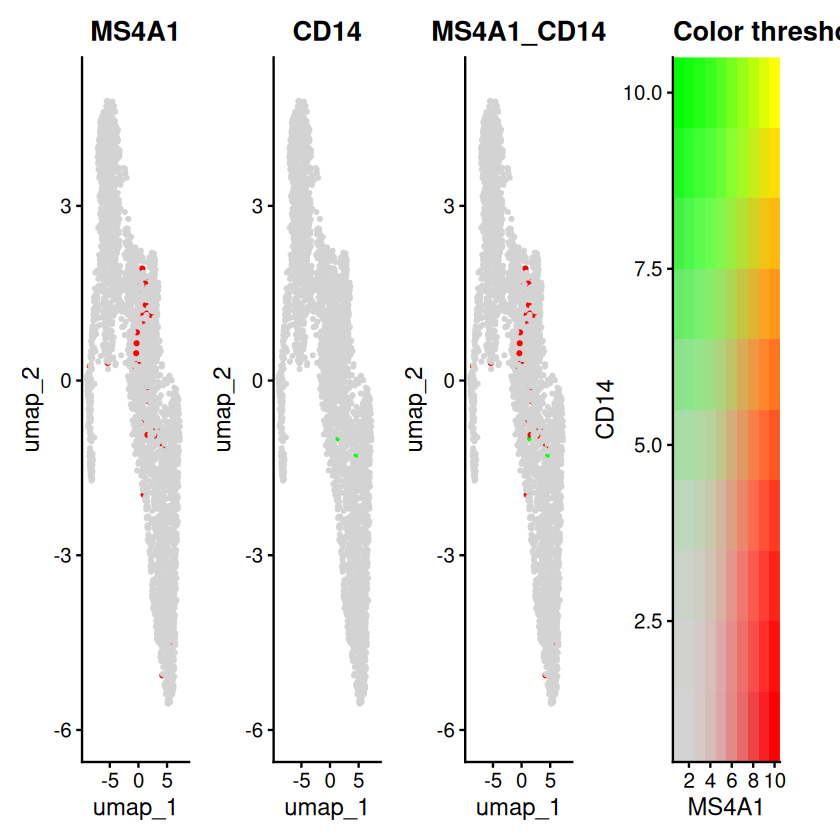

ERROR: [1m[33mError[39m in `FetchData()`:[22m
[33m![39m None of the requested variables were found: SingleR.labels


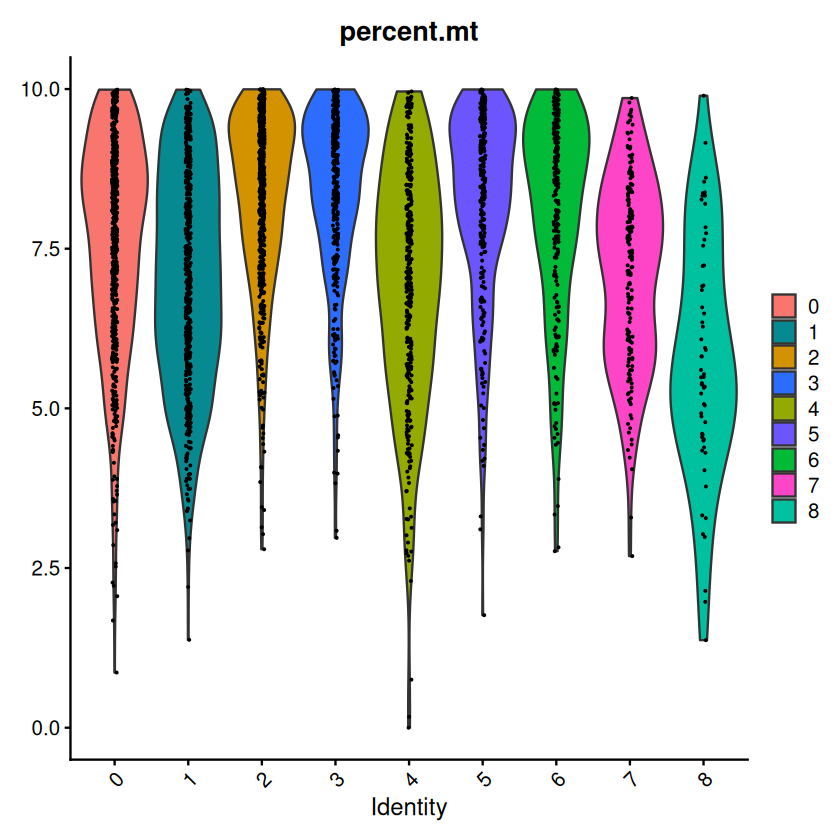

In [49]:
library(ggplot2)
library(patchwork)

features = c(B='Ms4a1',B='Cd19',MM='Cd14',MM='Lyz2',MM='Fcgr3',MM='Ms4a7',MM='Fcer1g',MM='Cst3',MM='H2-Aa',MM='Ly6d',
  rRNA='AY036118',rRNA='Gm42418',Mphase='Cenpa',Mphase='Ccnb2',Mphase='Birc5',Mphase='Mki67',Sphase='Pcna',
  Sphase='Mcm3',Sphase='Ccne2','T'='Cd8b','T'='Cd8a','T'='Cd4','T'='Cd3g','T'='Cd3e','T'='Cd3d')

# Convert all gene symbols to uppercase
features_upper <- toupper(features)

# Now check against the Seurat object
present_features <- features_upper[features_upper %in% rownames(zehn_s)]
missing_features <- features_upper[!features_upper %in% rownames(zehn_s)]

cat("✅ Present genes:\n")
print(present_features)

cat("\n❌ Missing genes:\n")
print(missing_features)

# Visualize #co-expression# of two features simultaneously # Yellow = red+green?
FeaturePlot(zehn_s, features = present_features[1:2], blend = TRUE)

head(zehn_s@meta.data)
VlnPlot(zehn_s, features = "percent.mt", split.by = "seurat_clusters")
VlnPlot(zehn_s, features = "percent.mt", split.by = "SingleR.labels")
VlnPlot(zehn_s, features = "percent.mt", split.by = "orig.ident")

DotPlot(zehn_s, features = present_features, split.by = "SingleR.labels", 
        cols = c("blue", "red", "green")) + RotatedAxis() ## Combined labels for meaningful grouping

#DoHeatmap(zehn_s, features = VariableFeatures(zehn_s)[1:20], cells = 1:42, size = 4,
#          angle = 90) + NoLegend()

plot <- DimPlot(zehn_s, reduction = "pca") + NoLegend()
LabelClusters(plot = plot, id = "ident")

Picking joint bandwidth of 2.98e-06

Picking joint bandwidth of 2.93e-06

Picking joint bandwidth of 2.91e-06

Picking joint bandwidth of 2.93e-06

Picking joint bandwidth of 3.46e-06

Picking joint bandwidth of 3.06e-06

Picking joint bandwidth of 0.0238

Picking joint bandwidth of 0.0408

Picking joint bandwidth of 0.0394

Picking joint bandwidth of 0.0305

Picking joint bandwidth of 3.12e-06

Picking joint bandwidth of 0.212

Picking joint bandwidth of 0.236

Picking joint bandwidth of 2.97e-06

Picking joint bandwidth of 0.305

Picking joint bandwidth of 0.328

Picking joint bandwidth of 0.283



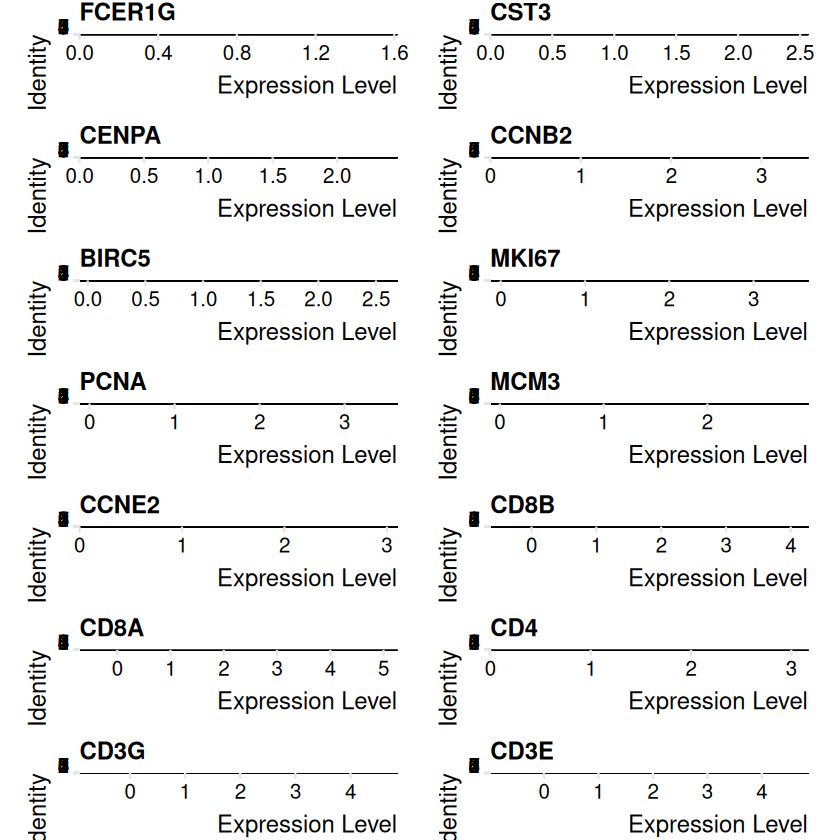

In [41]:
#----------------Ridge plots
RidgePlot(zehn_s, features = present_features, ncol = 2) # Visualize single cell expression distributions in each cluster

#Idents(zehn_s)
#table(zehn_s$SingleR.labels)

#markers <- FindAllMarkers(zehn_s, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
#head(markers)

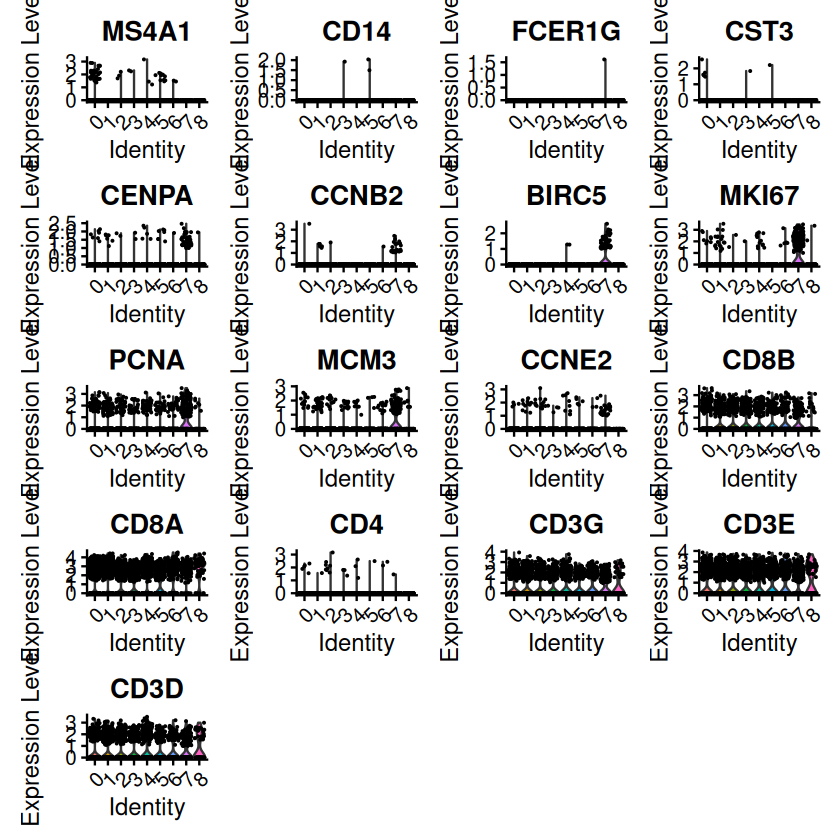

In [48]:
#----------------Vioin plots
VlnPlot(zehn_s, features = present_features)

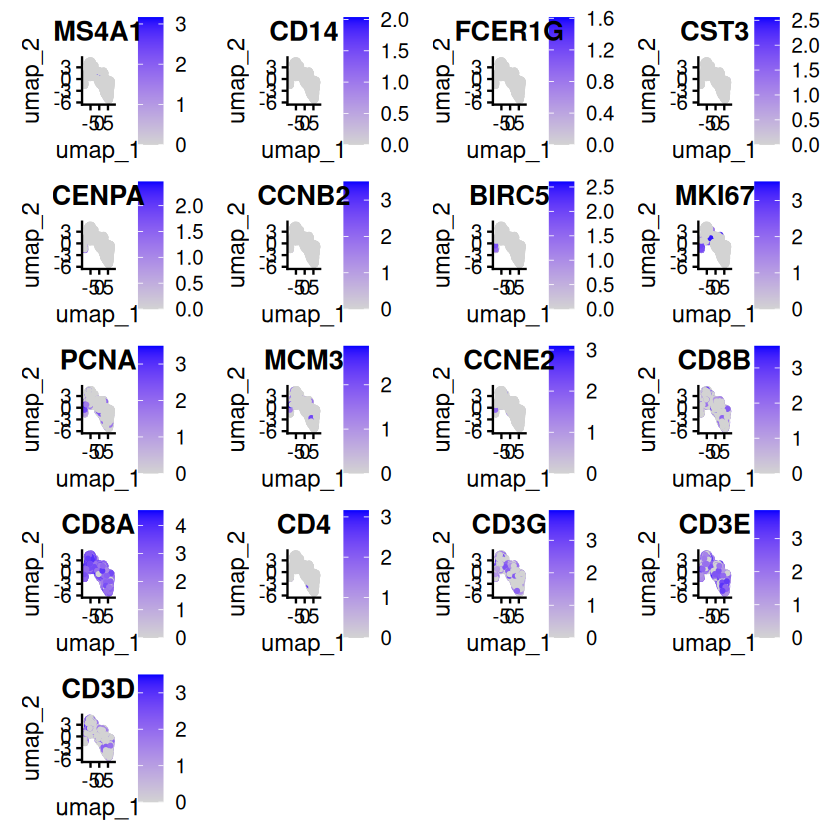

In [47]:
#----------------Feauture plots
FeaturePlot(zehn_s, features = present_features)

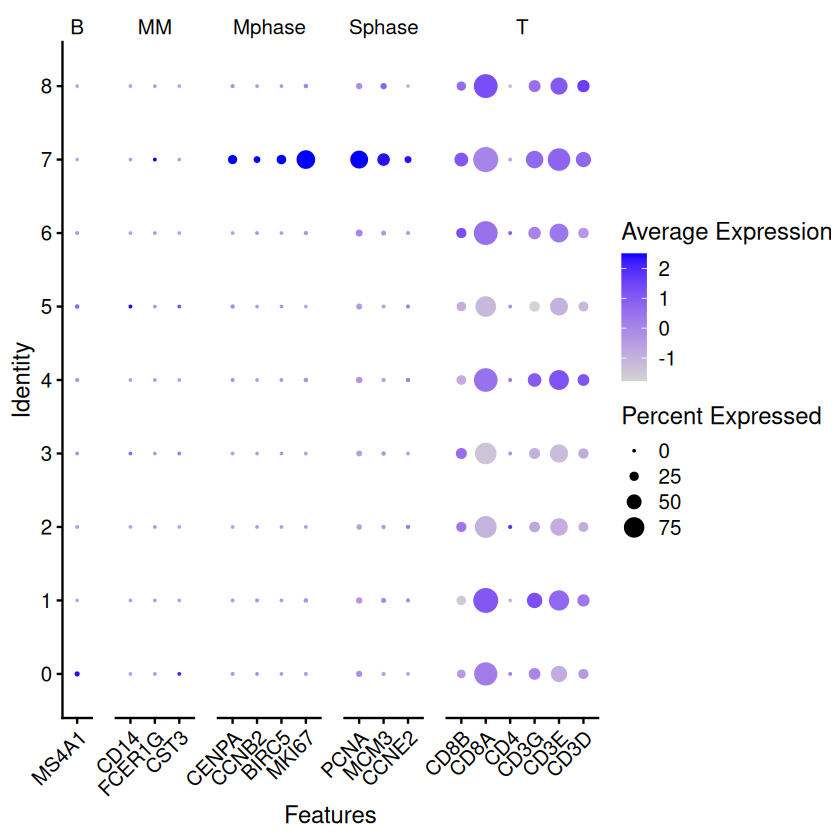

In [45]:
# DotPlots
DotPlot(zehn_s, features = present_features) + RotatedAxis() #per gene

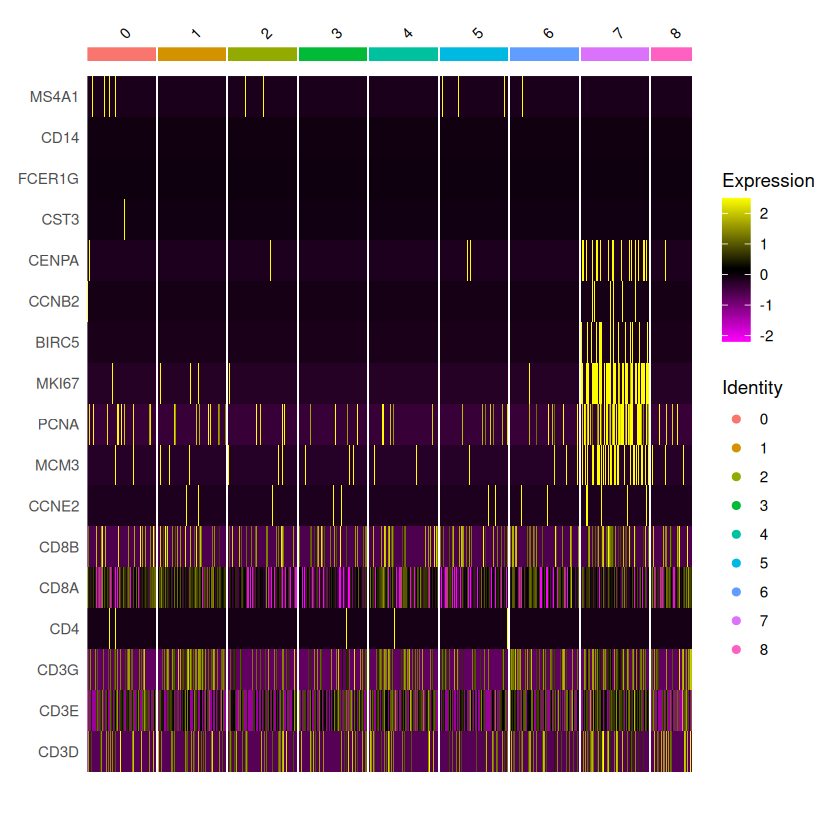

In [46]:
DoHeatmap(subset(zehn_s, downsample = 100), features = present_features, size = 3) # NK cells inflated due to hierarchical clustering??

In [37]:
# Convert all gene symbols to uppercase
features_upper <- toupper(features)

# Now check against the Seurat object
present_features <- features_upper[features_upper %in% rownames(zehn_s)]
missing_features <- features_upper[!features_upper %in% rownames(zehn_s)]

cat("✅ Present genes:\n")
print(present_features)

cat("\n❌ Missing genes:\n")
print(missing_features)

✅ Present genes:
       B       MM       MM       MM   Mphase   Mphase   Mphase   Mphase 
 "MS4A1"   "CD14" "FCER1G"   "CST3"  "CENPA"  "CCNB2"  "BIRC5"  "MKI67" 
  Sphase   Sphase   Sphase        T        T        T        T        T 
  "PCNA"   "MCM3"  "CCNE2"   "CD8B"   "CD8A"    "CD4"   "CD3G"   "CD3E" 
       T 
  "CD3D" 

❌ Missing genes:
         B         MM         MM         MM         MM         MM       rRNA 
    "CD19"     "LYZ2"    "FCGR3"    "MS4A7"    "H2-AA"     "LY6D" "AY036118" 
      rRNA 
 "GM42418" 


In [36]:
head(rownames(zehn_s), 20)


[1] "A1BG"        "A1BG-AS1"    "A1CF"        "A2M"         "A2M-AS1"    
 [6] "A2ML1"       "A2ML1-AS1"   "A3GALT2"     "AAAS"        "AACS"       
[11] "AACSP1"      "AADACL2-AS1" "AADACL3"     "AAGAB"       "AAK1"       
[16] "AAMDC"       "AAMP"        "AANAT"       "AAR2"        "AARS1"

In [ ]:
# SCTransform

library(Seurat)
library(ggplot2)
library(sctransform)

#install.packages('BiocManager')
#BiocManager::install('glmGamPoi')

# run sctransform
# this single command replaces NormalizeData(), ScaleData(), and FindVariableFeatures() #install glmGamPoi
zehn_s <- SCTransform(zehn, vars.to.regress = "percent.mt", verbose = FALSE) #No filtering based on mito. contamination

# Standard steps in the Seurat workflow for visualization and clustering
#PCA and UMAP embedding
zehn_s <- RunPCA(zehn_s, verbose = FALSE)
zehn_s <- RunUMAP(zehn_s, dims = 1:20, verbose = FALSE)

zehn_s <- FindNeighbors(zehn_s, dims = 1:20, verbose = FALSE)
zehn_s <- FindClusters(zehn_s, verbose = FALSE)
DimPlot(zehn_s, label = TRUE)

ncol(zehn_s)

# Visualize canonical marker genes on the sctransform embedding.